## Imports y datasets

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer

RANDOM_STATE = 42

In [29]:
original = pd.read_csv('Datasets/hotels_procesado.csv').copy()
train = pd.read_csv('Datasets/train_encoded.csv').copy()
test = pd.read_csv('Datasets/test_encoded.csv').copy()

## K-Nearest Neighbors

### Split

In [30]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

In [31]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


### Grid Search

In [35]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':[5], 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean']
             }

folds = 5

kfoldcv = StratifiedKFold(n_splits=folds)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Clasificador KNN
knn = KNeighborsClassifier()

gs = GridSearchCV(knn, params_grid, cv=folds, scoring=scorer_fn, verbose=2)

gs.fit(x_train, y_train)
gs.cv_results_['mean_test_score']

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=distance; total time=  13.3s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=distance; total time=   8.4s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=distance; total time=  12.3s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=distance; total time=   7.7s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=distance; total time=   7.7s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform; total time=  10.1s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform; total time=   8.3s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform; total time=   9.9s
[CV] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform; total time=   8.6s
[CV] END algorithm=ball_tree, metric=euclide

array([0.58838833, 0.58972098, 0.58838833, 0.58972098, 0.58837285,
       0.58970544])

In [36]:
print('Mejores parámetros: {}'.format(gs.best_params_))
print('Mejor métrica: {}'.format(gs.best_score_))

Mejores parámetros: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Mejor métrica: 0.589720982830831


In [37]:
#Mejor estimador
best_knn=gs.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

In [42]:
knn = KNeighborsClassifier().set_params(**gs.best_params_)
modelo = knn.fit(x_train, y_train)

In [43]:
y_pred = modelo.predict(x_test)

In [44]:
print(f'Best Training Accuracy: {modelo.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo.score(x_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(gs.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.7307754355775435
Best Testing Accuracy: 0.5873902132998745
Cross-val-score: 0.5860120988109172


In [45]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5873902132998745
Recall: 0.5984213122841638
Precision: 0.5936620579958399
f1 score: 0.5960321847552362


              precision    recall  f1-score   support

           0       0.58      0.58      0.58      7832
           1       0.59      0.60      0.60      8108

    accuracy                           0.59     15940
   macro avg       0.59      0.59      0.59     15940
weighted avg       0.59      0.59      0.59     15940



Text(50.722222222222214, 0.5, 'True')

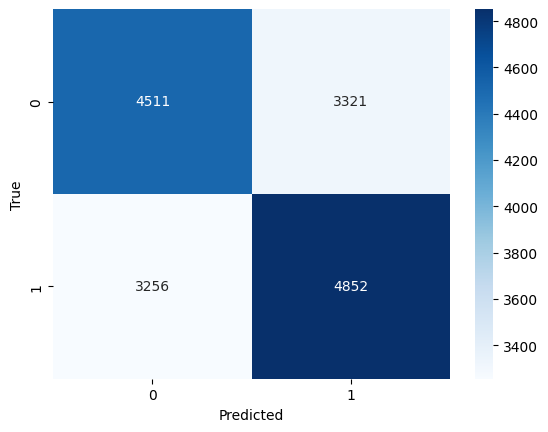

In [46]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')